<a href="https://colab.research.google.com/github/MoritzLaurer/zeroshot-classifier/blob/main/2_data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install and setup

In [ ]:
!pip install transformers[sentencepiece]~=4.33.0 -qqq
!pip install datasets~=2.14.0 -qqq
!pip install accelerate~=0.21.0 -qqq
# for automatic dataset cleaning
!pip install cleanlab~=2.4.0 -qqq
!pip install sentence-transformers~=2.2.2 -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... d

In [ ]:
## load packages
import transformers
import torch

import pandas as pd
import numpy as np
import os
from datasets import load_dataset

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
from cleanlab.dataset import health_summary
from cleanlab.classification import CleanLearning
import warnings
from sklearn.exceptions import ConvergenceWarning
import time
import tqdm

from google.colab.data_table import DataTable
from google.colab import data_table
from IPython.display import display
data_table.enable_dataframe_formatter() # https://colab.research.google.com/notebooks/data_table.ipynb#scrollTo=JgBtx0xFFv_i

# set global seed for reproducibility and against seed hacking
SEED_GLOBAL = 42
np.random.seed(SEED_GLOBAL)

In [ ]:
## connect to google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

#set wd
print(os.getcwd())
os.chdir("/content/drive/My Drive/PhD/zero-shot-models")
print(os.getcwd())

Mounted at /content/drive
/content
/content/drive/My Drive/PhD/zero-shot-models


### Overarching functions

In [ ]:
# model for automatic cleaning
# choose model from MTEB leaderboard: https://huggingface.co/spaces/mteb/leaderboard
sbert_embedder = SentenceTransformer("BAAI/bge-base-en-v1.5")

In [ ]:
# overall dataset health statistics https://docs.cleanlab.ai/stable/cleanlab/dataset.html

def dataset_health_analysis(texts_encoded=None, df=None, random_state=42):
    model = LogisticRegression(max_iter=500, random_state=random_state)
    pred_probs = cross_val_predict(model, texts_encoded, df["label_standard"], cv=5, method="predict_proba")

    summary = health_summary(labels=df["label_standard"], pred_probs=pred_probs, verbose=False)

    # add label text to columns
    label_text_map_alphabetical = {i: label_text for i, label_text in enumerate(df.label_text.factorize(sort=True)[1])}
    summary["classes_by_label_quality"]["Class Text"] = summary["classes_by_label_quality"]["Class Index"].map(label_text_map_alphabetical)
    summary["overlapping_classes"]["Class Label A"] = summary["overlapping_classes"]["Class Index A"].map(label_text_map_alphabetical)
    summary["overlapping_classes"]["Class Label B"] = summary["overlapping_classes"]["Class Index B"].map(label_text_map_alphabetical)

    return summary


def cleanlab_cleaning(texts_encoded=None, df=None, random_state=42, label_quality_thresh=0.5, min_output_per_class=5, verbose=True):

    # find label issues
    model = LogisticRegression(max_iter=500, random_state=random_state)
    cl = CleanLearning(
        model, cv_n_folds=5,
        find_label_issues_kwargs={  # https://docs.cleanlab.ai/stable/cleanlab/filter.html#cleanlab.filter.find_label_issues
            "filter_by": "prune_by_noise_rate",
            "min_examples_per_class": min_output_per_class
        }
    )
    df_all_quality = cl.find_label_issues(
        X=texts_encoded, labels=df["label_standard"],  #train_labels,
    )

    # add text and label_text
    df_all_quality["text"] = df["text"].to_list()
    df_all_quality["given_label_text"] = df["label_text"].to_list()
    # add label_text for prediction
    # ! careful: this can lead to mismatches between df_all_quality and df in the numeric labels, if df's labels were not created with factorize
    label_text_map_alphabetical = {i: label_text for i, label_text in enumerate(df.label_text.factorize(sort=True)[1])}
    df_all_quality["predicted_label_text"] = df_all_quality.predicted_label.map(label_text_map_alphabetical)
    # remove unnecessary columns
    df_all_quality = df_all_quality.drop(["given_label", "predicted_label"], axis=1)

    ## cleaning decision
    # remove label issues identified with cleanlab find_label_issues method
    print("Total texts: ", len(df_all_quality))
    df_all_quality_to_remove_1 = df_all_quality[df_all_quality["is_label_issue"] == True]
    print("Issues identified via prune_by_noise_rate: ", len(df_all_quality_to_remove_1))
    # remove labels with low label quality, but keep at least N
    # Step 1: Sort the dataframe by quality and identify the top N for each class to keep at least N
    sorted_df = df_all_quality.sort_values(by=['given_label_text', 'label_quality'], ascending=[True, False])
    df_top_n_per_class = sorted_df.groupby('given_label_text').head(min_output_per_class)
    # Step 2: Filter out rows below the threshold
    df_low_quality = df_all_quality[df_all_quality.label_quality < label_quality_thresh]
    # Step 3: keep at least the top N for each class among low quality
    df_all_quality_to_remove_2 = df_low_quality[~df_low_quality.index.isin(df_top_n_per_class.index)]
    print("Issues identified via label quality: ", len(df_all_quality_to_remove_2))

    indices_to_remove = set(df_all_quality_to_remove_1.index.to_list() + df_all_quality_to_remove_2.index.to_list())
    print("Total texts to remove: ", len(indices_to_remove))
    print("Make sure to reset index of initial df so that indices_to_remove align with df.index")

    if verbose:
        # label imbalance analysis
        df_cl = df[~df.index.isin(indices_to_remove)]
        df_label_balance_change = pd.DataFrame({
            "label_distribution_original": df.label_text.value_counts(),
            "label_distribution_clean": df_cl.label_text.value_counts(),
        })
        display(df_label_balance_change)

        df_all_quality.label_quality.plot.hist(
            bins=10, xlabel="label quality", title="Label quality distribution"
        )

    return indices_to_remove, df_all_quality



### Automatic data cleaning

In [ ]:
import os

def find_train_files(directory):
    # List all files dataset directory
    all_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    # Filter files that have the word "train" in the filename
    # only clean train datasets
    train_files = [f for f in all_files if "train" in os.path.basename(f)]
    return train_files

directory_path = './datasets_standardized'
train_files_lst = find_train_files(directory_path)
print(train_files_lst)

# remove specific datasets where automatic cleaning won't add value
datasets_no_automatic_clean = ["trueteacher", "anthropic_harmless", "anthropic_helpful"]
train_files_lst = [path for path in train_files_lst if not any(dataset in path for dataset in datasets_no_automatic_clean)]
print(train_files_lst)

['./datasets_standardized/ds_wellformedquery_train.gzip', './datasets_standardized/ds_rottentomatoes_train.gzip', './datasets_standardized/ds_amazonpolarity_train.gzip', './datasets_standardized/ds_imdb_train.gzip', './datasets_standardized/ds_yelpreviews_train.gzip', './datasets_standardized/ds_hatexplain_train.gzip', './datasets_standardized/ds_massive_train.gzip', './datasets_standardized/ds_banking77_train.gzip', './datasets_standardized/ds_emotiondair_train.gzip', './datasets_standardized/ds_emocontext_train.gzip', './datasets_standardized/ds_empathetic_train.gzip', './datasets_standardized/ds_agnews_train.gzip', './datasets_standardized/ds_yahootopics_train.gzip', './datasets_standardized/ds_biasframes_offensive_train.gzip', './datasets_standardized/ds_biasframes_sex_train.gzip', './datasets_standardized/ds_biasframes_intent_train.gzip', './datasets_standardized/ds_financialphrasebank_train.gzip', './datasets_standardized/ds_appreviews_train.gzip', './datasets_standardized/ds_hat

In [ ]:

def clean_dataset(dataset_path=None, max_input_per_class=10_000,
                  label_quality_thresh=0.5, min_output_per_class=10, max_output_per_class=1_000,
                  verbose=True, health_summary=False, embedding_batch_size=32):

    print("*** Dataset being cleaned ***")
    print(f"*** {dataset_path} ***\n")
    df = pd.read_parquet(dataset_path).reset_index(drop=True)

    # downsample for faster iterations
    df = df.groupby("label_text", as_index=False, group_keys=False).apply(
        lambda x: x.sample(min(max_input_per_class, len(x)), random_state=SEED_GLOBAL)
    ).reset_index(drop=True)

    # encode texts with sbert model
    # https://www.sbert.net/docs/package_reference/SentenceTransformer.html#sentence_transformers.SentenceTransformer.encode
    texts_encoded = sbert_embedder.encode(
        df["text"].to_list(),
        batch_size=embedding_batch_size, show_progress_bar=True, normalize_embeddings=False
    )

    #if not verbose:
    warnings.simplefilter('ignore', ConvergenceWarning)
    #else:
    #    warnings.simplefilter('default', ConvergenceWarning)

    # overall dataset health
    if health_summary:
        summary = dataset_health_analysis(texts_encoded=texts_encoded, df=df)
        display(summary["classes_by_label_quality"])
        display(summary["overlapping_classes"])

    indices_to_remove, df_all_quality = cleanlab_cleaning(
        texts_encoded=texts_encoded,
        df=df, random_state=SEED_GLOBAL,
        label_quality_thresh=label_quality_thresh, min_output_per_class=10,
        verbose=verbose
    )

    # add quality score to final dataset
    # adding index column to enable merging on them and eliminate risk of merging issues due to text duplicates or similar
    df["index"] = df.index
    df_all_quality["index"] = df_all_quality.index
    df = df.merge(df_all_quality[["label_quality", "text", "given_label_text", "index"]], left_on=["text", "label_text", "index"], right_on=["text", "given_label_text", "index"], how="left")
    df = df.drop(columns=["index", "given_label_text"]).reset_index(drop=True)
    df_all_quality = df_all_quality.drop(columns=["index"]).reset_index(drop=True)

    # remove noisy rows
    df_cl = df[~df.index.isin(indices_to_remove)]

    # downsample to account for imbalance
    df_cl = df_cl.groupby("label_text", as_index=False, group_keys=False).apply(
        lambda x: x.sample(min(max_output_per_class, len(x)), random_state=SEED_GLOBAL)
    )

    return df_cl, df_all_quality



Dataset iterations:   0%|          | 0/25 [00:00<?, ?it/s]

*** Dataset being cleaned ***
*** ./datasets_standardized/ds_wellformedquery_train.gzip ***



Batches:   0%|          | 0/64 [00:00<?, ?it/s]

Total texts:  16239
Issues identified via prune_by_noise_rate:  2595
Issues identified via label quality:  3993
Total texts to remove:  3993
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
well_formed,8256,6768
not_well_formed,7983,5478


,text,label_text,label_standard,label_quality
5817,Does steel conduct electrivity ?,not_well_formed,0,0.543258
9593,How much hp does the 2008 suzuki gsxr600 make ?,well_formed,1,0.698949
7354,Antifreeze leak on a 96 nissan altima ?,not_well_formed,0,0.694749
10195,What is 375 grams of sugar in cups ?,well_formed,1,0.598093
6807,What is the roles and fuction of the head nurse ?,not_well_formed,0,0.527441
8864,What is the normal MCV ?,well_formed,1,0.520641
388,Who did Johann Sebastion Bach marry yo ?,not_well_formed,0,0.773054
15862,What is the sole purpose of fermentation ?,well_formed,1,0.557321
14444,Are there any fun and free websites for tweens ?,well_formed,1,0.772862
8456,What did Robert Owen do to change factory life ?,well_formed,1,0.821792


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_rottentomatoes_train.gzip ***



Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Total texts:  9596
Issues identified via prune_by_noise_rate:  594
Issues identified via label quality:  1365
Total texts to remove:  1365
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
negative,4798,4097
positive,4798,4134


,text,label_text,label_standard,label_quality
46,"it's not the worst comedy of the year , but it...",negative,0,0.897797
2005,if ever a concept came handed down from the mo...,negative,0,0.739702
8009,daring and beautifully made .,positive,1,0.947604
221,"literally nothing in the pool is new , but if ...",negative,0,0.918465
2025,"as david letterman and the onion have proven ,...",negative,0,0.756084
1059,"a horrible , 99-minute stink bomb .",negative,0,0.962105
2051,this is the sort of low-grade dreck that usual...,negative,0,0.983790
3657,there's suspension of disbelief and then there...,negative,0,0.970243
7946,"these are lives worth watching , paths worth f...",positive,1,0.969235
4139,"the jokes are sophomoric , stereotypes are spr...",negative,0,0.976985


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_amazonpolarity_train.gzip ***



Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Total texts:  20000
Issues identified via prune_by_noise_rate:  204
Issues identified via label quality:  901
Total texts to remove:  901
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
negative,10000,9559
positive,10000,9540


,text,label_text,label_standard,label_quality
11199,Excellent\nI knew nothing about the internet b...,positive,1,0.987882
525,Lied in description.\nlied about how long the ...,negative,0,0.989876
13177,Very Very Very Addicting\nOne of the best game...,positive,1,0.990922
7678,Useless\nI needed some inexpensive locks to se...,negative,0,0.996149
19685,Perfect Debut!\nDiano has such a beautiful and...,positive,1,0.989065
2452,"Didn't work\nFollowed the directions, turned t...",negative,0,0.986364
6686,"Misleading\nThis is the same movie as ""Largo W...",negative,0,0.577190
15735,Totally entertaining !!!\nThe re-mastered vers...,positive,1,0.995189
4220,"Good miniseries, horrible transfer\nThe dvd tr...",negative,0,0.972220
14106,Rock Classic\nHas everything you need in a alb...,positive,1,0.893266


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_imdb_train.gzip ***



Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Total texts:  20000
Issues identified via prune_by_noise_rate:  479
Issues identified via label quality:  1550
Total texts to remove:  1550
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
negative,10000,9167
positive,10000,9283


,text,label_text,label_standard,label_quality
7859,"Just think, it cost a total of $250,000 to mak...",negative,0,0.933792
2917,"""Serum"" starts out with credits that are quite...",negative,0,0.962080
7542,"Okay, I rented this movie because of the direc...",negative,0,0.995715
15656,Julie Waters is always marvelous but Adrian Pa...,positive,1,0.976112
8833,Christ. A sequel to one of the most cloying fi...,negative,0,0.982608
7105,Dolph Lundgren broods and scowls his way throu...,negative,0,0.994845
7678,"Strained comedy, a sketch-like revue which was...",negative,0,0.879637
18861,This tale based on two Edgar Allen Poe pieces ...,positive,1,0.952488
3025,Watched this on DVD in original language with ...,negative,0,0.986329
14477,I agree whole-heartedly with the comments so f...,positive,1,0.980560


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_yelpreviews_train.gzip ***



Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Total texts:  20000
Issues identified via prune_by_noise_rate:  65
Issues identified via label quality:  666
Total texts to remove:  666
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
negative,10000,9682
positive,10000,9652


,text,label_text,label_standard,label_quality
4917,Their policy on asking for my ID for an energy...,negative,0,0.905071
4286,Please tell me what I need to do to have you g...,negative,0,0.933038
8591,Photos and decor are better than the taste of ...,negative,0,0.998516
9970,I really REALLY wanted to like this place. The...,negative,0,0.948281
2729,Very disappointed with this Best Buy location....,negative,0,0.999879
16495,I had some work done here and they were great....,positive,1,0.998636
9301,Absolutely disgusting. If you purchased the Gr...,negative,0,0.998900
14521,We have worked with Suzanne on 3 projects now ...,positive,1,0.978913
19892,Highly recommend Hubbard Swim School on 32nd S...,positive,1,0.991004
3400,Was really looking forward to trying this new ...,negative,0,0.986863


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_hatexplain_train.gzip ***



Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Total texts:  8871
Issues identified via prune_by_noise_rate:  1022
Issues identified via label quality:  2407
Total texts to remove:  2407
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
neither,4620,3985
hate_speech,2666,2000
offensive,1585,479


,text,label_text,label_standard,label_quality
4752,rep steve cohen of tennessee announced thursda...,neither,1,0.930572
5936,she a dyke and i am a femme it a synonym,neither,1,0.770144
6480,<user> <user> <user> the source you are neglec...,neither,1,0.915500
644,hope they keep getting hit fuck spics what has...,hate_speech,0,0.902798
3815,<user> i used to hate you so much for liking h...,neither,1,0.910715
8714,it was then that gay retard world revealed its...,offensive,2,0.744357
8437,prolly heard i was a hoe from a hoe,offensive,2,0.554184
8353,make a retard nut call that shit a download,offensive,2,0.794834
5110,had a dream my lyft was trying to kidnap me i ...,neither,1,0.880818
3891,what a good carry out spot on the eastside nea...,neither,1,0.709778


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_massive_train.gzip ***



Batches:   0%|          | 0/53 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/cleanlab/filter.py:907: UserWarning: May not flag all label issues in class: 10, it has too few examples (see `min_examples_per_class` argument)
  warnings.warn(


Total texts:  13488
Issues identified via prune_by_noise_rate:  1114
Issues identified via label quality:  3993
Total texts to remove:  4001
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
alarm_query,149,116
alarm_remove,92,61
alarm_set,213,164
audio_volume_down,60,12
audio_volume_mute,125,75
audio_volume_other,18,7
audio_volume_up,121,76
calendar_query,668,415
calendar_remove,357,321
calendar_set,938,790


,text,label_text,label_standard,label_quality
5577,cook some coffees,iot_coffee,22,0.793906
9805,describe the statue of liberty,qa_definition,44,0.777213
9193,open sirius app and play the classical channel,play_radio,42,0.859206
8665,i want to hear chopin now,play_music,40,0.742181
5901,olly can you please turn off the light of my b...,iot_hue_lightoff,25,0.749190
2365,calendar invite for breakfast with sarah at ei...,calendar_set,9,0.812708
6233,make a new list for school supplies,lists_createoradd,30,0.830683
2897,what are the steps for biryani meal,cooking_recipe,11,0.643085
4328,i'd like to send a reply,email_sendemail,17,0.870089
5651,make the living room light orange,iot_hue_lightchange,23,0.574944


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_banking77_train.gzip ***



Batches:   0%|          | 0/40 [00:00<?, ?it/s]

Total texts:  10003
Issues identified via prune_by_noise_rate:  156
Issues identified via label quality:  3960
Total texts to remove:  3960
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
Refund_not_showing_up,162,129
activate_my_card,159,137
age_limit,110,104
apple_pay_or_google_pay,126,106
atm_support,87,53
...,...,...
virtual_card_not_working,41,10
visa_or_mastercard,135,106
why_verify_identity,121,71
wrong_amount_of_cash_received,180,121


,text,label_text,label_standard,label_quality
4771,Why have I been charged an extra £1?,extra_charge_on_statement,35,0.534335
2792,I have never been charged for making an ATM ca...,cash_withdrawal_charge,20,0.875674
8295,"Hi, I was looking over my card receipts for th...",transaction_charged_twice,63,0.601906
5369,Am I gonna be charged for sending out more cards?,getting_spare_card,40,0.655764
6241,"I went to an ATM to get cash, but the app says...",pending_cash_withdrawal,47,0.728677
293,My card needs to be activated.,activate_my_card,1,0.804963
3939,"There is a direct debit that I didn't set up, ...",direct_debit_payment_not_recognised,29,0.779503
3882,I got a message that my transfer was declined.,declined_transfer,28,0.739085
4584,Can this app be used to exchange currencies?,exchange_via_app,34,0.642361
1089,I made a deposit but it is not showing up in m...,balance_not_updated_after_cheque_or_cash_deposit,7,0.689934


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_emotiondair_train.gzip ***



Batches:   0%|          | 0/71 [00:00<?, ?it/s]

Total texts:  17962
Issues identified via prune_by_noise_rate:  2599
Issues identified via label quality:  6788
Total texts to remove:  6788
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
joy,6051,4650
sadness,5214,3657
anger,2429,1181
fear,2145,1168
love,1474,382
surprise,649,136


,text,label_text,label_standard,label_quality
12000,i touch you with my feelings hold you with my ...,love,3,0.848583
1501,i will start to feel resentful,anger,0,0.532295
13922,im feeling as though this is all pretty boring,sadness,4,0.755644
10210,im actually feeling hopeful,joy,2,0.958930
6055,i reply because they make me feel pretty,joy,2,0.942613
1287,i feel very angry and upset with my customer,anger,0,0.968191
17756,i feel so amazed with myself as i could stride...,surprise,5,0.665596
3970,i began to feel very afraid of disappointment ...,fear,1,0.626341
9591,i can keep another writer from spending four y...,joy,2,0.919184
8000,day i received my te score and acceptance into...,joy,2,0.845476


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_emocontext_train.gzip ***



Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Total texts:  25023
Issues identified via prune_by_noise_rate:  2325
Issues identified via label quality:  5783
Total texts to remove:  5783
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
others,10000,8040
angry,5448,4140
sad,5362,4137
happy,4213,2923


,text,label_text,label_standard,label_quality
18346,do you ever go out yeah mostly on wednesday miss,others,2,0.902812
22491,iam feeling alone why would that be i dunno ma...,sad,3,0.942480
24827,she did hurt me badly who told u this hhh am ...,sad,3,0.833955
18542,inception avengers the dark knight and inte...,others,2,0.696314
17726,ohhh i see in which exam good luck x all the ...,others,2,0.667083
19266,then tell about it yeah they did but artists h...,others,2,0.939805
319,i'm better than roman reigns john cena is the ...,angry,0,0.869574
15506,gd nyt goodnight iam so tide,others,2,0.827347
19332,lets do something fun but what should we do yo...,others,2,0.839446
11927,hmm i get it because i get it good for you,others,2,0.834258


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_empathetic_train.gzip ***



Batches:   0%|          | 0/81 [00:00<?, ?it/s]

Total texts:  20607
Issues identified via prune_by_noise_rate:  6871
Issues identified via label quality:  18493
Total texts to remove:  18494
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
afraid,677,29
angry,721,9
annoyed,733,65
anticipating,636,10
anxious,654,31
apprehensive,495,10
ashamed,515,10
caring,552,34
confident,662,31
content,604,60


,text,label_text,label_standard,label_quality
8324,"Context: one time when I was in preschool, I h...",embarrassed,13,0.752583
18994,Context: My parents threw me a surprise party ...,surprised,29,0.658398
7943,Context: We're cleaning up/renovating a home t...,disgusted,12,0.542307
6824,Context: I have received news that my brother ...,devastated,10,0.659778
4697,Context: I had to take care of my little broth...,caring,7,0.584660
9605,Context: I have been faithful to my long time ...,faithful,15,0.592608
10978,Context: My wife is the greatest person in my ...,grateful,17,0.511928
15677,"Context: When I drink coffee, memories from my...",nostalgic,24,0.515427
19137,Context: On my 29th birthday my wife invited a...,surprised,29,0.656425
15265,Context: I returned to my home town to visit p...,nostalgic,24,0.545011


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_agnews_train.gzip ***



Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Total texts:  40000
Issues identified via prune_by_noise_rate:  1435
Issues identified via label quality:  4033
Total texts to remove:  4033
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
Business,10000,8629
Sci/Tech,10000,8692
Sports,10000,9812
World,10000,8834


,text,label_text,label_standard,label_quality
19204,Ballmer: Windows Safer than Linux Microsoft CE...,Sci/Tech,1,0.928731
3022,arnings dip at Archipelago NEW YORK Chicago-ba...,Business,0,0.969242
13883,Apple iPod holds sway in Japan Juliana Sasaki ...,Sci/Tech,1,0.770991
17480,Study Confirms Pigeon Navigation Theory Nov. 2...,Sci/Tech,1,0.985842
11732,European Search Landscape - Search Engine Stra...,Sci/Tech,1,0.981510
34995,Can Lebanon weather possible economic sanction...,World,3,0.624110
4490,Henkel says will not issue bond to finance Dia...,Business,0,0.955356
7687,Automakers look to rev up sales with fun new a...,Business,0,0.832640
24483,Charlotte Bobcats Pick Up Option on Ely (AP) A...,Sports,2,0.998779
3225,Asian Stocks Slip as Oil Moves Above \$55 Asia...,Business,0,0.895433


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_yahootopics_train.gzip ***



Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Total texts:  100000
Issues identified via prune_by_noise_rate:  15300
Issues identified via label quality:  34544
Total texts to remove:  34544
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
Business & Finance,10000,4165
Computers & Internet,10000,8491
Education & Reference,10000,4013
Entertainment & Music,10000,6490
Family & Relationships,10000,7223
Health,10000,7701
Politics & Government,10000,7230
Science & Mathematics,10000,6920
Society & Culture,10000,4620
Sports,10000,8603


,text,label_text,label_standard,label_quality
87945,Question: It is mentioned in your Qur’an that ...,Society & Culture,8,0.853083
49613,Question: Will I ever find the one? I think of...,Family & Relationships,4,0.927090
90572,Question: Carling cup upsets tonight??? Cant s...,Sports,9,0.986202
79930,Question: Suggest a good topic or a good scie...,Science & Mathematics,7,0.671303
48060,Question: please answer the following...fun? 1...,Family & Relationships,4,0.566872
43325,Question: what is the first thing you look at ...,Family & Relationships,4,0.564436
61841,Question: Why are conservatives liberal until ...,Politics & Government,6,0.908892
92075,Question: What nationality is tennis player Da...,Sports,9,0.982141
48138,Question: My mom and dad are getting married a...,Family & Relationships,4,0.837270
51107,Question: what's best way to fight head cold? ...,Health,5,0.919515


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_biasframes_offensive_train.gzip ***



Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Total texts:  20000
Issues identified via prune_by_noise_rate:  1534
Issues identified via label quality:  3334
Total texts to remove:  3334
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
not_offensive,10000,8346
offensive,10000,8320


,text,label_text,label_standard,label_quality
34,Feel sorry for Blades who aren't here cos it's...,not_offensive,0,0.972504
9645,The worst and strange thing about this is Goss...,not_offensive,0,0.855996
9149,Smile.,not_offensive,0,0.857143
3813,25th Dec 2am the truce continues a German band...,not_offensive,0,0.957562
9564,#Technology\nI'm tired of fist fighting with a...,not_offensive,0,0.887004
8035,The booze thing should n't be a big deal .,not_offensive,0,0.808568
15423,You know why I hate having sex with German gir...,offensive,1,0.996262
12625,What's the best part of throwing a kid out of ...,offensive,1,0.851500
6831,What gauge copper sheeting did you use?,not_offensive,0,0.852256
13382,Calm down everyone instead of saying *that col...,offensive,1,0.945106


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_biasframes_sex_train.gzip ***



Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Total texts:  12636
Issues identified via prune_by_noise_rate:  262
Issues identified via label quality:  893
Total texts to remove:  893
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
not_sex,10000,9773
sex,2636,1970


,text,label_text,label_standard,label_quality
6241,If that was Cena he wouldn't of fucked up that...,not_sex,0,0.873808
8517,Anyone who kills a member of a boy-band deserv...,not_sex,0,0.987096
10676,how do you get a nun pregnant ? dress her up a...,sex,1,0.592031
1118,People really do have mental issues i wont put...,not_sex,0,0.993917
4286,Omg the orange cat saw me get out of my car an...,not_sex,0,0.954243
1629,What you gonna do if she cheat ? Cry ? Fight f...,not_sex,0,0.846370
8481,BITCH I THINK WE'RE TAKING A QUIZ ON THE PAGES...,not_sex,0,0.960160
7927,I got my wife in international television! Eve...,not_sex,0,0.969066
12625,"""@Tentalia """"Amount of times I jerk off and fi...",sex,1,0.938141
12023,what do <number> out of <number> people enjoy ...,sex,1,0.920710


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_biasframes_intent_train.gzip ***



Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Total texts:  20000
Issues identified via prune_by_noise_rate:  1305
Issues identified via label quality:  3108
Total texts to remove:  3108
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
intent,10000,8442
not_intent,10000,8450


,text,label_text,label_standard,label_quality
11184,I come into work and a few of my coworkers are...,not_intent,0,0.602122
10317,The house I'm watching my cousins animals at h...,not_intent,0,0.855657
5108,Why doesn’t it snow in Germany Because hitler ...,intent,1,0.934219
11658,"""funny how someone can tell you they love you ...",not_intent,0,0.744546
18090,Edgar really is one of biggest influencers. I ...,not_intent,0,0.971134
3160,I used the rape whistle I got as a college fre...,intent,1,0.784608
10296,We can all preach until we're all blue in the ...,not_intent,0,0.965665
2329,Your momma's so old she's got a separate entra...,intent,1,0.995558
2834,I saw this black guy run away from my street w...,intent,1,0.527038
13358,★ BEST ASIAN MASSAGE ON THE park slope --TOP R...,not_intent,0,0.931112


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_financialphrasebank_train.gzip ***



Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Total texts:  2758
Issues identified via prune_by_noise_rate:  76
Issues identified via label quality:  345
Total texts to remove:  345
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
neutral,1713,1639
positive,709,512
negative,336,262


,text,label_text,label_standard,label_quality
1275,The exercise price of the option will be based...,neutral,1,0.918838
2455,Both operating profit and turnover for the thr...,positive,2,0.981032
2670,Operating profit improved by 27 % to EUR 579.8...,positive,2,0.962038
429,KONE is listed on the Nordic Exchange in Helsi...,neutral,1,0.779647
1095,That address also happens to house Italian meg...,neutral,1,0.989588
1378,AffectoGenimap builds highly customised IT sol...,neutral,1,0.770535
1123,"The broker started UPM-Kymmene , Stora Enso an...",neutral,1,0.720695
354,"The process , technology , project management ...",neutral,1,0.883077
1961,The other actions include the cutting of the e...,neutral,1,0.696733
1608,"` Sanoma is a buyer not a target , ' he said .",neutral,1,0.833237


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_appreviews_train.gzip ***



Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Total texts:  16000
Issues identified via prune_by_noise_rate:  327
Issues identified via label quality:  1190
Total texts to remove:  1190
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
negative,8000,7597
positive,8000,7213


,text,label_text,label_standard,label_quality
13945,One that works for me Using it with 3rd party ...,positive,1,0.974776
8525,Came with a Rom now a staple. After playing w...,positive,1,0.981574
2051,Cannot save odt. It's a great thing to open an...,negative,0,0.764805
12388,Good for studying I love this app so kuh. I ev...,positive,1,0.984836
13910,Best app Telegram have software for computer v...,positive,1,0.974081
7962,Boring Why is it boring? Well first u don't ge...,negative,0,0.986523
15766,Wow. I used to have a real DEC VT-100. Now I h...,positive,1,0.960223
4545,Not working.!! It is not not working on my dev...,negative,0,0.881211
8231,Probably the best! Tournament and hobby player...,positive,1,0.992840
8956,It provides many crop lines to frame the pictu...,positive,1,0.959098


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_hateoffensive_train.gzip ***



Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Total texts:  3446
Issues identified via prune_by_noise_rate:  103
Issues identified via label quality:  395
Total texts to remove:  395
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
neither,1600,1524
offensive,1600,1451
hate_speech,246,76


,text,label_text,label_standard,label_quality
1078,@Josh_Ward thuggery? Cheating? Talking trash? ...,neither,1,0.547422
1152,Looking forward to #NCAA and #NBA basketball 🏀...,neither,1,0.960560
2059,"“@BroCulture: When life knocks you down, stand...",offensive,2,0.967983
1635,RT @PlMPCESS: A silent protest in Philadelphia...,neither,1,0.894208
3143,Free lil cj bitch the wait is over ! #december8th,offensive,2,0.896991
1346,That was a solid investment of 15 mins. Cue up...,neither,1,0.914679
2252,Nobody wit me im on all alone shit so dont thi...,offensive,2,0.929778
2512,@MadameCrystalB yes bitch. 😐😂,offensive,2,0.899524
1610,1X - The yellow tower by Gilbert Claes http://...,neither,1,0.965985
1727,Man arrested after 40 opened nip bottles of vo...,neither,1,0.861590


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_spam_train.gzip ***



Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Total texts:  4136
Issues identified via prune_by_noise_rate:  3
Issues identified via label quality:  75
Total texts to remove:  75
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
not_spam,3614,3606
spam,522,455


,text,label_text,label_standard,label_quality
453,Hi darlin im on helens fone im gonna b up the ...,not_spam,0,0.949891
10,In sch but neva mind u eat 1st lor..\n,not_spam,0,0.992580
4013,"all the lastest from Stereophonics, Marley, Di...",spam,1,0.619991
1430,Sorry . I will be able to get to you. See you ...,not_spam,0,0.990805
909,Huh but i cant go 2 ur house empty handed righ...,not_spam,0,0.992342
1663,On ma way to school. Can you pls send me ashle...,not_spam,0,0.924444
3166,"Haha awesome, I might need to take you up on t...",not_spam,0,0.996300
3441,Do ü all wan 2 meet up n combine all the parts...,not_spam,0,0.993965
2570,He is a womdarfull actor\n,not_spam,0,0.990194
3630,"Free Msg: get Gnarls Barkleys ""Crazy"" ringtone...",spam,1,0.784695


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_wikitoxic_toxicaggregated_train.gzip ***



Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Total texts:  20000
Issues identified via prune_by_noise_rate:  412
Issues identified via label quality:  1782
Total texts to remove:  1782
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
not_toxicaggregated,10000,9173
toxicaggregated,10000,9045


,text,label_text,label_standard,label_quality
10737,note stealing \n\nThe article note stealing in...,toxicaggregated,1,0.985578
18214,I asked you to fuck off. Its my talk page and...,toxicaggregated,1,0.921637
18512,Suck my horny dutch balls,toxicaggregated,1,0.986496
8195,Jellyfish. \n\nHello Shirik. I am leaving you ...,not_toxicaggregated,0,0.686107
3839,Theres no evidence that the Ninjas had their o...,not_toxicaggregated,0,0.871227
16675,"DAHN IS ILLITERATE AND HAS A SMALL PENIS\nYes,...",toxicaggregated,1,0.978707
4680,"And, by the way, stop writing that Frau Rathle...",not_toxicaggregated,0,0.964129
12353,I think I might sit here all day and call you ...,toxicaggregated,1,0.992478
19796,"This is RIDICULOUS \n\nDude, all of this stuff...",toxicaggregated,1,0.824095
5526,"""\n\nProposal\n\nLook all I am saying is that ...",not_toxicaggregated,0,0.959213


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_wikitoxic_obscene_train.gzip ***



Batches:   0%|          | 0/73 [00:00<?, ?it/s]

Total texts:  18449
Issues identified via prune_by_noise_rate:  260
Issues identified via label quality:  1329
Total texts to remove:  1329
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
not_obscene,10000,9418
obscene,8449,7702


,text,label_text,label_standard,label_quality
14711,"Im not writing about myself, i made this accou...",obscene,1,0.901134
11688,FUCKAN STOP CHANGON IT OR I AM TWIST OFF YOURE...,obscene,1,0.987156
8069,"""OK, I intend to make some changes to the desc...",not_obscene,0,0.933534
15339,"I tried living off Guiness for a few weeks, I ...",obscene,1,0.620807
13266,Let me give you a clue. I don't give a fuck wh...,obscene,1,0.935199
17735,. fukk it im goin 2 encyclopedia dramatica,obscene,1,0.790195
782,"""\n\nSockpuppetry case\n \nYou have been accus...",not_obscene,0,0.972016
3394,"""\n\n Self-published sources \n\nPlease do not...",not_obscene,0,0.987155
2018,"""\n\nRand is not a philosopher\nI don't think ...",not_obscene,0,0.935569
17806,!!!!!!!!!!!!!!!!!!!!! \n\nGO TO HELL ASSHOLE!!...,obscene,1,0.999413


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_wikitoxic_threat_train.gzip ***



Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Total texts:  1434
Issues identified via prune_by_noise_rate:  14
Issues identified via label quality:  90
Total texts to remove:  90
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
not_threat,956,924
threat,478,420


,text,label_text,label_standard,label_quality
320,please go to following marathi books\n\nI am p...,not_threat,0,0.885067
556,hello everyone I hope someone looks me up anyt...,not_threat,0,0.788347
1258,"""\n\n I Hate Grandma Terri \n\nI hate my step...",threat,1,0.639290
401,"""\n\n Mass Deletions and synopsis \n\nAt this ...",not_threat,0,0.981788
310,"""\n\n CSD \n\nI just CSD'd Robert F. Brands, a...",not_threat,0,0.978953
207,"""\n Speedy deletion of """"John falls"""" \n\n A p...",not_threat,0,0.950995
1333,hello \n\nI would like to draw your attention ...,threat,1,0.683593
711,Of course I do. Can you please state your othe...,not_threat,0,0.864830
1216,Read you mother fucker or you shall fucking di...,threat,1,0.960928
784,"""\nDon't you know by now Garnet that bullying ...",not_threat,0,0.906282


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_wikitoxic_identityhate_train.gzip ***



Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Total texts:  4215
Issues identified via prune_by_noise_rate:  52
Issues identified via label quality:  274
Total texts to remove:  274
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
not_identityhate,2810,2687
identityhate,1405,1254


,text,label_text,label_standard,label_quality
839,How could the capital of Israel not be part of...,identityhate,1,0.935605
21,"YOU FUCKERS THINK YOU CAN STOP ME, YOU REALLY ...",identityhate,1,0.876757
1346,"You fucking guinea wop, greaseball, guido, new...",identityhate,1,0.956026
3117,Please do not add nonsense to Wikipedia. It is...,not_identityhate,0,0.984505
2998,Thank you Crazynas - you truly seem to be the ...,not_identityhate,0,0.920683
3759,"The National Register Information System, the ...",not_identityhate,0,0.968231
435,7\n\nHey you a meani head who change my fun fa...,identityhate,1,0.922613
3263,"""Official full name is """"7.62-mm Dragunov snip...",not_identityhate,0,0.959469
1212,graham broad is a total loser. yes website woo...,identityhate,1,0.939190
412,Are you a faggot or what?,identityhate,1,0.967747


*** Dataset being cleaned ***
*** ./datasets_standardized/ds_wikitoxic_insult_train.gzip ***



Batches:   0%|          | 0/70 [00:00<?, ?it/s]

Total texts:  17877
Issues identified via prune_by_noise_rate:  285
Issues identified via label quality:  1271
Total texts to remove:  1271
Make sure to reset index of initial df so that indices_to_remove align with df.index


,label_distribution_original,label_distribution_clean
not_insult,10000,9400
insult,7877,7206


,text,label_text,label_standard,label_quality
15636,"""\n\nLiphook\nI removed Liphook from the list ...",not_insult,0,0.974631
9597,I think thsi is a gayu website,not_insult,0,0.901207
7743,"Take this how you will, but you suck Big Black...",insult,1,0.964113
3800,This guy is such a loser,insult,1,0.989909
2868,"""\n\n Must be """"Tali-Ihantala 1944"""" where Fin...",insult,1,0.611826
474,JLaTondre is a gay boy who likes to suck dick ...,insult,1,0.985910
15045,"""\nI was right going to report this guy to WP:...",not_insult,0,0.638423
5501,I fuck niggas! I fuck niggas! I fuck niggas! I...,insult,1,0.948928
17189,I think the trivia section is far too small in...,not_insult,0,0.977297
7105,"Fuck you, Smith. Please have me notified when ...",insult,1,0.941697


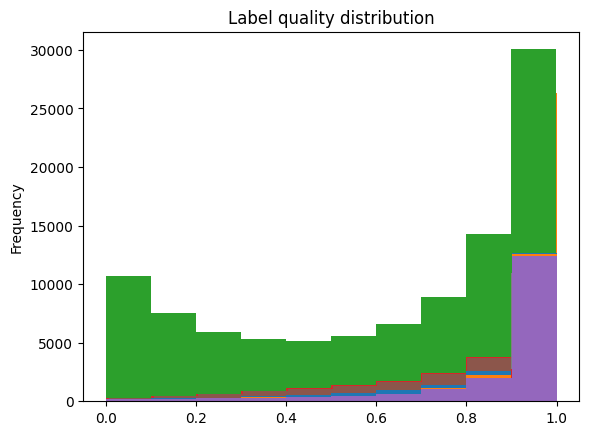

In [ ]:
# cleaning loop

df_cl_dic = {}
df_all_quality_dic = {}
for dataset_path in tqdm.notebook.tqdm(train_files_lst, desc="Dataset iterations"):

    df_cl, df_all_quality = clean_dataset(
        dataset_path=dataset_path, max_input_per_class=10_000,
        label_quality_thresh=0.5, min_output_per_class=10, max_output_per_class=10_000,
        verbose=True, health_summary=False, embedding_batch_size=64*4
    )
    df_cl_dic.update({dataset_path: df_cl})
    df_all_quality_dic.update({dataset_path: df_all_quality})

    # display sample of cleaned data
    display(df_cl.sample(frac=1.0, random_state=SEED_GLOBAL).head(10))

    # sleep to allow tables to display for inspection before next iter
    time.sleep(2)


### Overall cleaned data statistics

In [ ]:

# count text per class after cleaning
n_texts_per_class_cl = pd.Series(dtype=object)
for key_dataset_path, value_df_cl in df_cl_dic.items():
    n_texts_per_class_cl = pd.concat([n_texts_per_class_cl, value_df_cl.label_text.value_counts()])
n_texts_per_class_cl = pd.DataFrame(n_texts_per_class_cl, columns=["label_text"])

# text per class before cleaning
n_texts_per_class = pd.Series(dtype=object)
for key_dataset_path, value_df_all_quality in df_all_quality_dic.items():
    n_texts_per_class = pd.concat([n_texts_per_class, value_df_all_quality.given_label_text.value_counts()])
n_texts_per_class = pd.DataFrame(n_texts_per_class, columns=["label_text"])

df_n_texts_per_class = n_texts_per_class_cl.merge(
    n_texts_per_class, left_index=True, right_index=True, suffixes=["_cl", ""]
)

# statistics:
print("Total texts before cleaning: ", df_n_texts_per_class.label_text.sum())
print("Total texts after cleaning: ", df_n_texts_per_class.label_text_cl.sum())

print("\nClasses in total: ", len(df_n_texts_per_class.label_text_cl))
print("\nTasks in total: ", len(df_cl_dic.keys()))

print("\nLabel distribution after/before cleaning:\n", df_n_texts_per_class, "\n")


Total texts before cleaning:  963688
Total texts after cleaning:  818488

Classes in total:  308

Tasks in total:  25

Label distribution after/before cleaning:
                                          label_text_cl  label_text
Business                                          8629       10000
Business & Finance                                4165       10000
Computers & Internet                              8491       10000
Education & Reference                             4013       10000
Entertainment & Music                             6490       10000
...                                                ...         ...
weather_query                                      649         695
well_formed                                       6768        8256
why_verify_identity                                 71         121
wrong_amount_of_cash_received                      121         180
wrong_exchange_rate_for_cash_withdrawal             91         163

[308 rows x 2 columns] 



### Saving data to disk

In [ ]:
# save cleaned data to disk
save_to_disk = True

if save_to_disk:
    for key_dataset_path, value_df in df_cl_dic.items():
        key_dataset_path_cl = key_dataset_path.replace(".gzip", "").replace("datasets_standardized", "datasets_clean") + "_cl.gzip"
        value_df.to_parquet(key_dataset_path_cl, compression='gzip')
